# Terrain Classification - Jamie's Manual Data
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ', 'ACCELEROMETER XY (m/s²)']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_manual/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Jamie' not in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)
    
    
    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time',]

In [7]:
# List all datasets
dataset_labels

['Synthesis_AsphaltDonutJamie_Module',
 'Middle_LinoleumF8Jamie_Module6050',
 'Right_GrassStraightJamie_Module',
 'Middle_ConcreteStraightJamie_Module6050',
 'Middle_GrassStraightJamie_Module6050',
 'Middle_ConcreteF8Jamie_Module6050',
 'Middle_GrassDonutJamie_Module6050',
 'Right_ConcreteF8Jamie_Module',
 'Synthesis_GrassDonutJamie_Module',
 'Left_SidewalkStraightJamie_Module',
 'Left_GrassDonutJamie_Module',
 'Synthesis_AsphaltF8Jamie_Module',
 'Middle_GravelStraightJamie_Module6050',
 'Synthesis_AsphaltStraightJamie_Module',
 'Synthesis_GravelDonutJamie_Module',
 'Middle_SidewalkStraightJamie_Module6050',
 'Left_GravelF8Jamie_Module',
 'Left_AsphaltDonutJamie_Module',
 'Middle_CarpetDonutJamie_Module6050',
 'Middle_CarpetF8Jamie_Module6050',
 'Left_LinoleumStraightJamie_Module',
 'Synthesis_LinoleumStraightJamie_Module',
 'Left_GrassStraightJamie_Module',
 'Middle_LinoleumStraightJamie_Module6050',
 'Right_SidewalkDonutJamie_Module',
 'Left_SidewalkF8Jamie_Module',
 'Right_ConcreteS

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
1234,2.487819,0.020244,0.012099,-5.475531,-7.764967,-0.611722,9.501376,-0.013951,-0.005399,0.057961,-3.767365,-9.077377,0.605068,9.797485,0.007164,0.033122,0.072247,3.703,1.565202e+09
1235,-0.261876,0.019458,0.013005,-5.485108,-7.770952,-0.624890,9.511788,-0.010223,-0.007529,0.054498,-3.780533,-9.096530,0.651755,9.805426,0.007697,0.035253,0.073845,3.706,1.565202e+09
1236,0.144032,0.019890,0.014365,-5.507852,-7.767361,-0.672774,9.521992,-0.012619,-0.009127,0.054765,-3.763774,-9.092939,0.706820,9.797432,0.006099,0.035253,0.073046,3.709,1.565202e+09
1237,-0.196407,0.019301,0.015120,-5.444407,-7.731449,-0.632073,9.456049,-0.013951,-0.011790,0.052102,-3.748211,-9.090545,0.632601,9.767138,0.006099,0.033921,0.070116,3.712,1.565202e+09
1238,0.052375,0.019458,0.013912,-5.500670,-7.726660,-0.715868,9.484653,-0.012353,-0.014986,0.053699,-3.828416,-9.061815,0.658937,9.798268,0.005566,0.031525,0.070649,3.715,1.565202e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

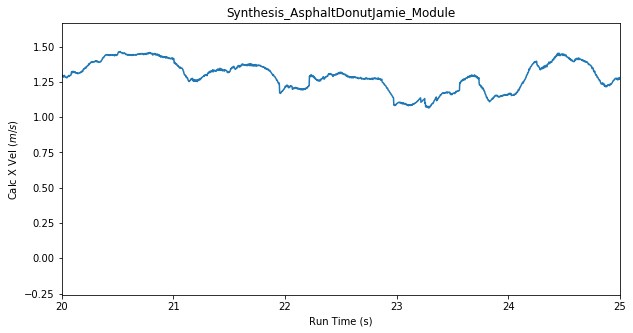

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'Calc X Vel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

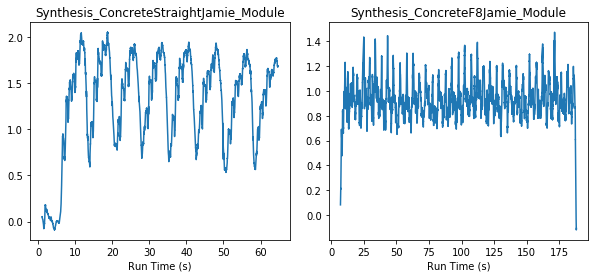

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Synthesis' in label and 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Calc X Vel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 80
Shape of first dataset: (21681, 19)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

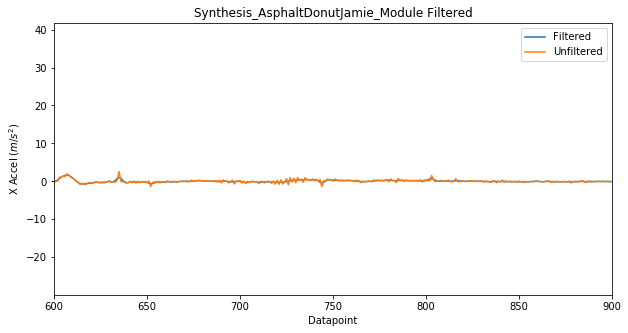

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 80
Shape of first filtered dataset: (21681, 19)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
0,2.487657,0.020244,0.012098,-5.475519,-7.764976,-0.611763,9.501376,-0.013952,-0.005398,0.057960,-3.767356,-9.077416,0.605150,9.797456,0.007164,0.033122,0.072246,3.703,1.565202e+09
1,0.820213,0.019819,0.013410,-5.485095,-7.764866,-0.636179,9.506817,-0.012677,-0.007404,0.055365,-3.765493,-9.091910,0.653391,9.791343,0.006905,0.034335,0.072649,3.706,1.565202e+09
2,-0.178940,0.019540,0.014267,-5.488688,-7.756475,-0.656494,9.502039,-0.012098,-0.009711,0.053665,-3.767902,-9.093840,0.675658,9.787659,0.006473,0.034666,0.072463,3.709,1.565202e+09
3,-0.366575,0.019459,0.014507,-5.483723,-7.741637,-0.667532,9.487059,-0.012321,-0.012108,0.053176,-3.776158,-9.081732,0.666049,9.790686,0.005964,0.034087,0.071674,3.712,1.565202e+09
4,-0.119231,0.019513,0.014393,-5.472282,-7.731535,-0.666509,9.472219,-0.012983,-0.013940,0.053461,-3.788104,-9.066579,0.641003,9.802588,0.005649,0.033282,0.070727,3.715,1.565202e+09


<Figure size 432x288 with 0 Axes>

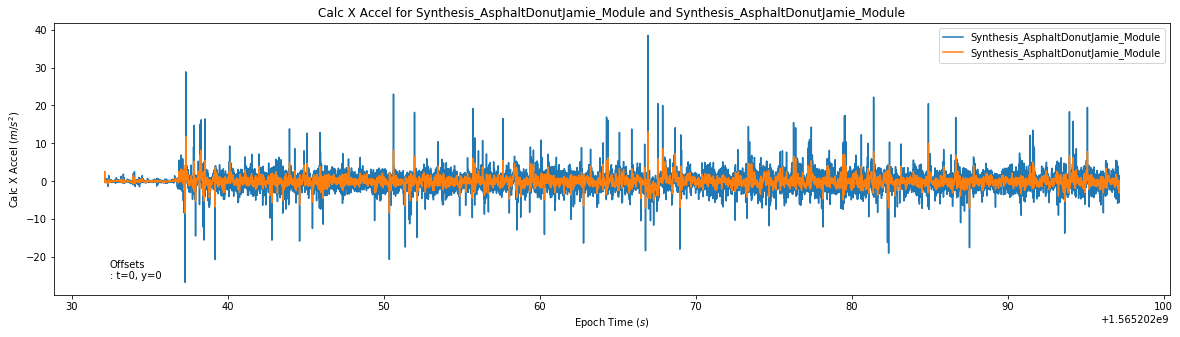

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'Calc X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [38]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''
#

'for terrain in terrains:\n    for movement in movements:\n        # Identifier at end of label\n        label_suffix = terrain + movement + \'_Module\'\n        \n        # Set index to epoch time for easier time alignment\n        left = datasets[\'Left_\' + label_suffix].set_index(\'Epoch Time\')\n        right = datasets[\'Right_\' + label_suffix].set_index(\'Epoch Time\')\n        middle = datasets[\'Middle_\' + label_suffix + \'6050\'].set_index(\'Epoch Time\')\n        synthesis = datasets[\'Synthesis_\' + label_suffix].set_index(\'Epoch Time\')\n        \n        # Join the wheel data columns, only where they overlap in Epoch Time\n        dataset_wheels = pd.concat([left, right], axis=1, join=\'inner\')\n        dataset_wheels = dataset_wheels.reset_index()\n        \n        # Save as a csv and add to dataset dictionary\n        wheels_label = \'Wheels_\' + label_suffix\n        dataset_wheels.to_csv(\'imu_data/\' + wheels_label + \'.csv\', index=False)\n        datasets.upda

In [32]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [33]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [34]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 80
Num of windows in first dataset: 65
Shape of individual window: (333, 19)


In [35]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
328,-0.019437,0.004579,-0.017682,-5.440758,-7.834190,-0.700827,9.538186,0.004025,0.009083,0.031106,-4.221206,-8.937715,0.748730,9.791131,0.003347,0.035674,0.043669,4.687,1.565202e+09
329,-0.053603,0.004418,-0.017509,-5.453902,-7.816395,-0.698559,9.531059,0.004629,0.008322,0.030408,-4.252434,-8.961040,0.852407,9.795246,-0.000833,0.037496,0.042473,4.690,1.565202e+09
330,-0.098883,0.004121,-0.017260,-5.460564,-7.807320,-0.704889,9.527409,0.004934,0.006834,0.029183,-4.212129,-8.857088,0.827382,9.802165,-0.001379,0.037220,0.041051,4.693,1.565202e+09
331,-0.107119,0.003800,-0.016862,-5.455935,-7.809096,-0.704843,9.526235,0.004513,0.004338,0.027743,-4.155340,-8.723076,0.685181,9.807034,0.002580,0.034865,0.039516,4.696,1.565202e+09
332,-0.064477,0.003607,-0.016178,-5.441144,-7.814482,-0.687320,9.522226,0.003320,0.001151,0.026485,-4.138739,-8.689588,0.535876,9.807295,0.005341,0.032535,0.037936,4.699,1.565202e+09


<Figure size 432x288 with 0 Axes>

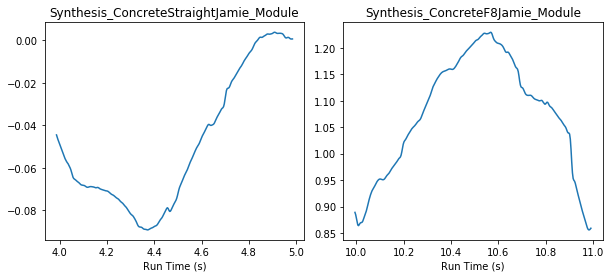

In [39]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label and 'Synthesis' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Calc X Vel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [40]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [41]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [42]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 80
Num of FFT'd windows in first dataset: 103
Shape of FFT'd individual window: (60, 7)


,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Frequency
0,0.007493,0.003437,0.000083,5.381485,7.826430,0.607022,9.499429,0.007070,0.003487,0.011726,3.772432,9.052321,0.621550,9.816249,0.004244,0.009062,0.047102,0.000000
1,0.048475,0.007910,0.003858,0.082155,0.057940,0.009302,0.001626,0.001968,0.003785,0.023630,0.169264,0.067164,0.006237,0.000966,0.010885,0.030525,0.044262,1.000901
2,0.015317,0.001537,0.002428,0.031206,0.016606,0.013640,0.003945,0.002108,0.005841,0.005508,0.092921,0.046748,0.010341,0.006456,0.007203,0.018121,0.013800,2.001802
3,0.018112,0.001272,0.002909,0.001091,0.003594,0.008708,0.002977,0.002513,0.001994,0.001749,0.042936,0.017484,0.032709,0.002213,0.005005,0.006410,0.001833,3.002703
4,0.005224,0.000287,0.003509,0.028829,0.015514,0.009338,0.004384,0.001789,0.002943,0.002188,0.087587,0.032027,0.019018,0.000297,0.003370,0.004979,0.011221,4.003604


<Figure size 432x288 with 0 Axes>

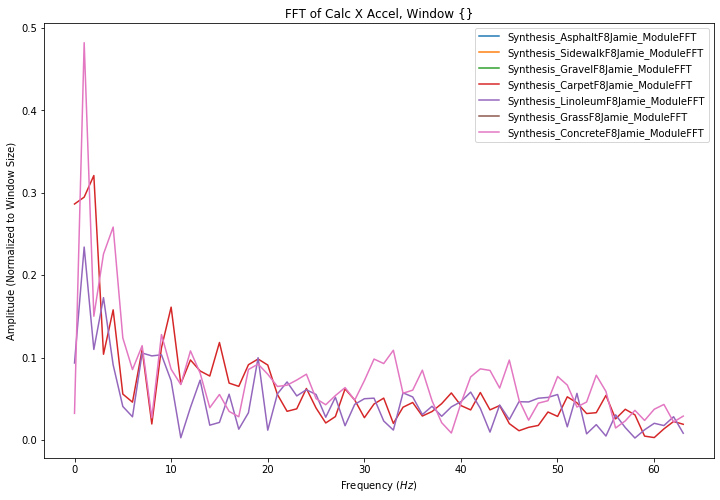

In [43]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

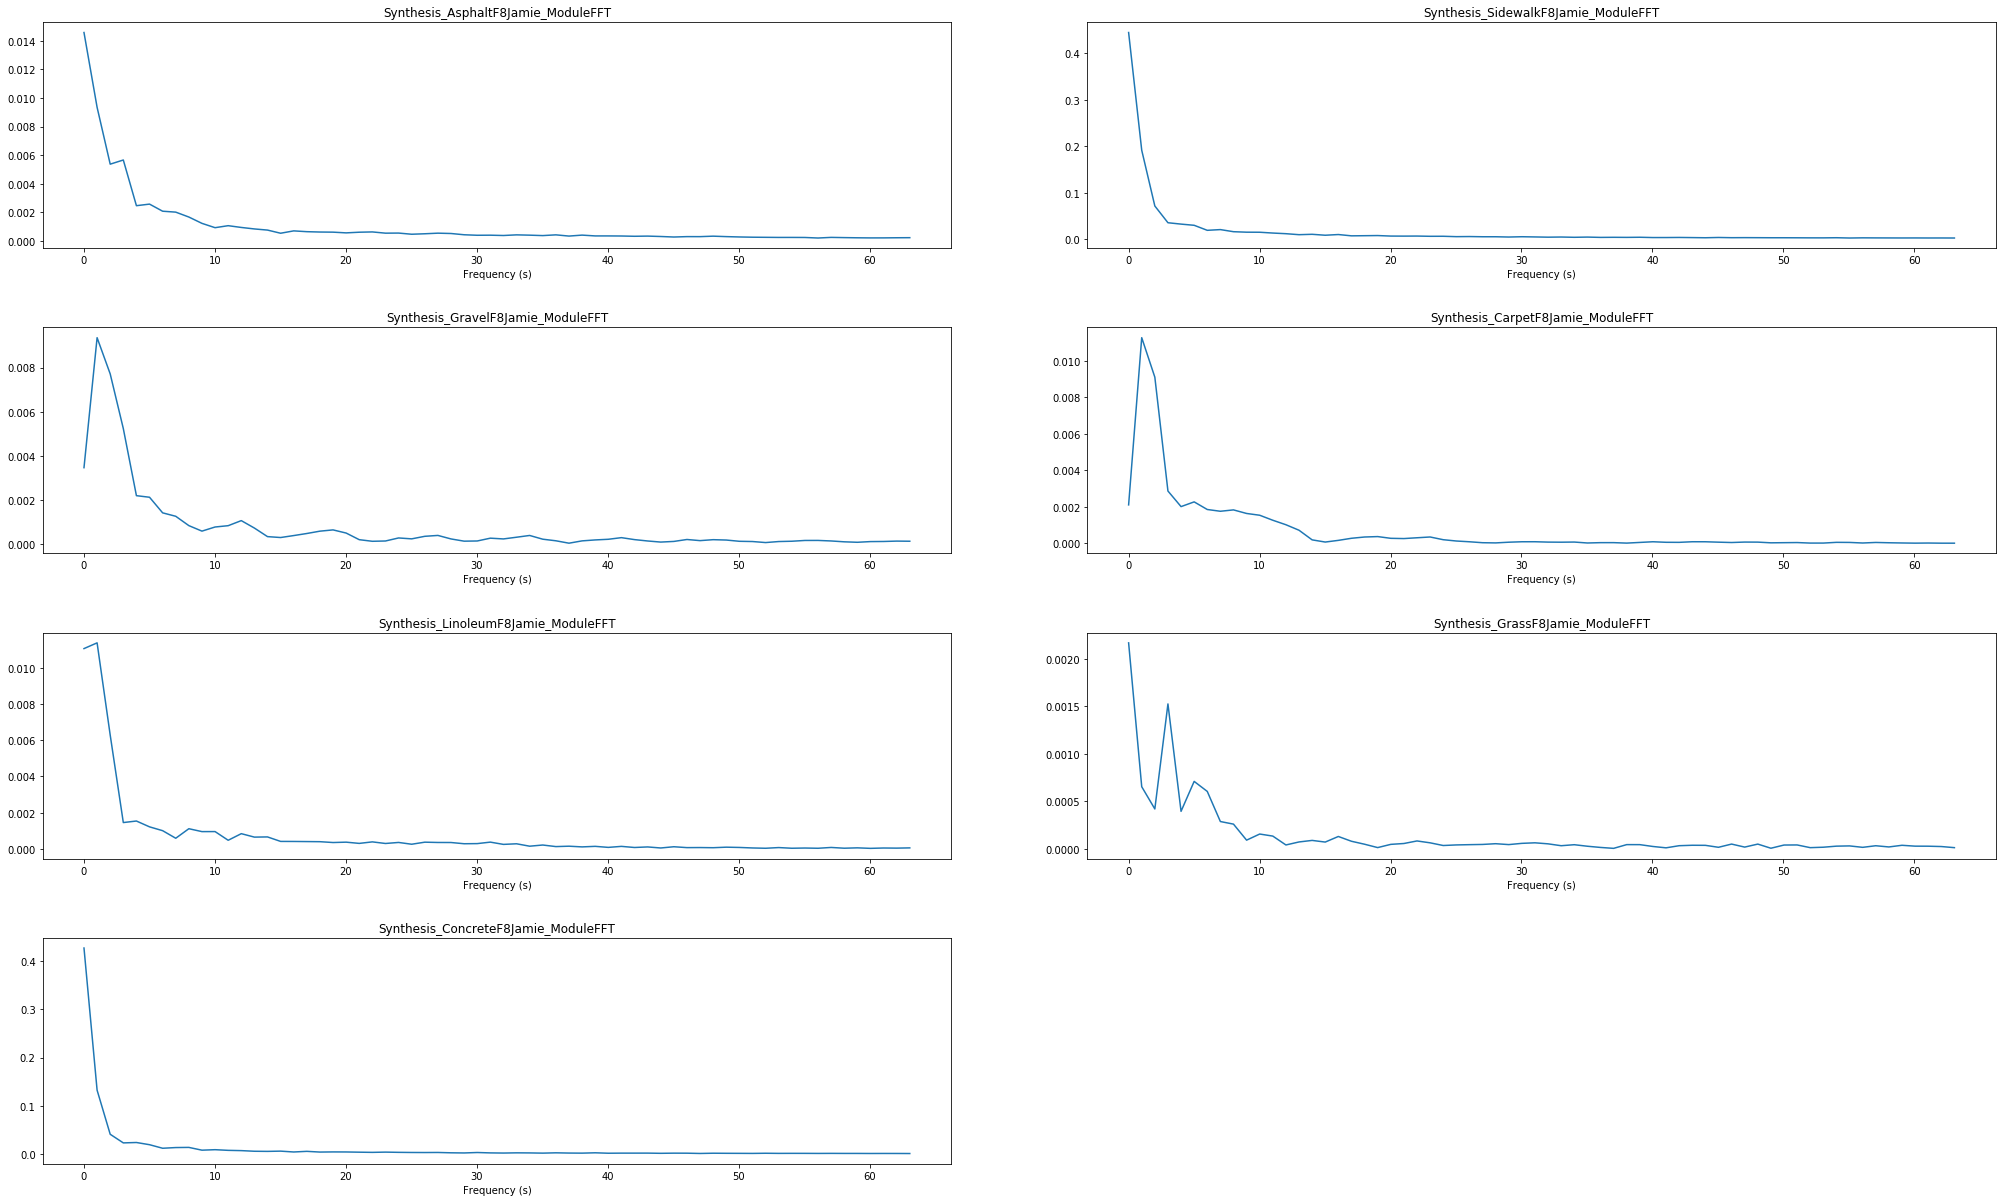

In [44]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Vel', windowed=True)

### Part (b) - PSD

In [45]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [46]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 80
Num of PSD'd windows in first dataset: 65
Shape of PSD'd individual window: (64, 18)


<Figure size 432x288 with 0 Axes>

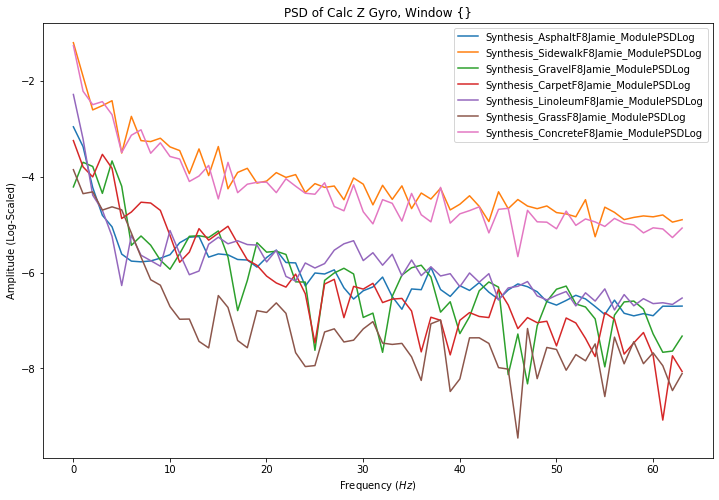

In [47]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

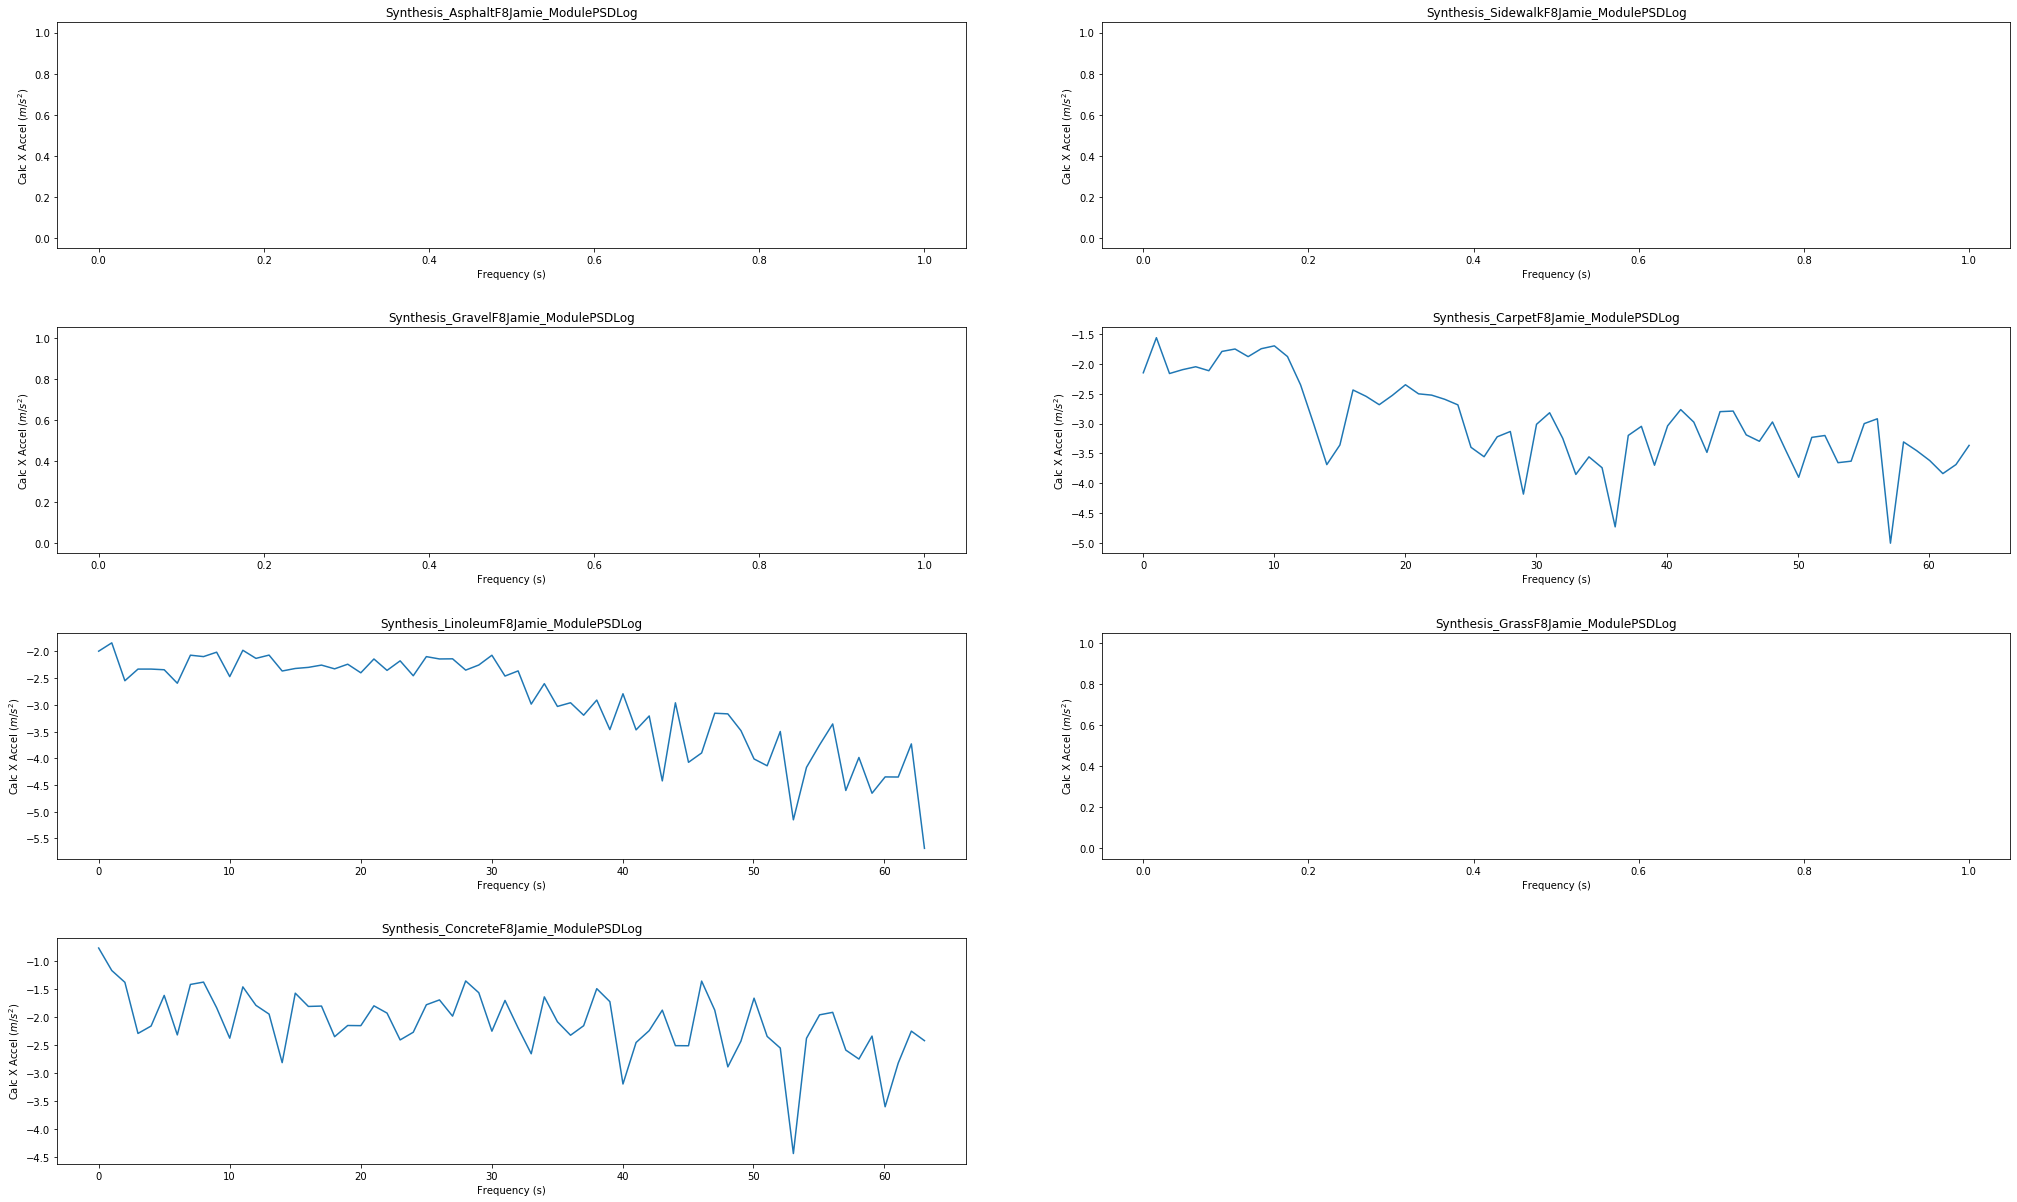

In [48]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [49]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

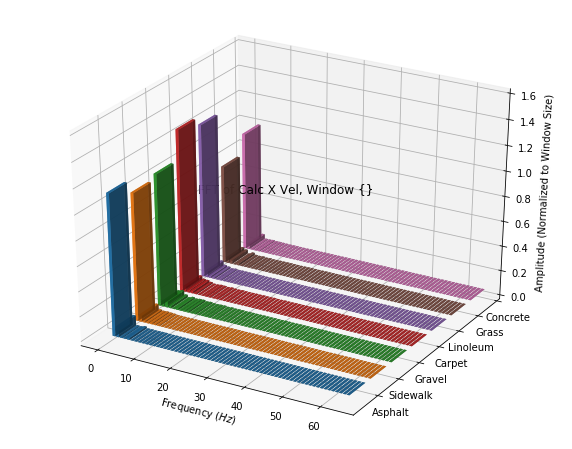

In [50]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

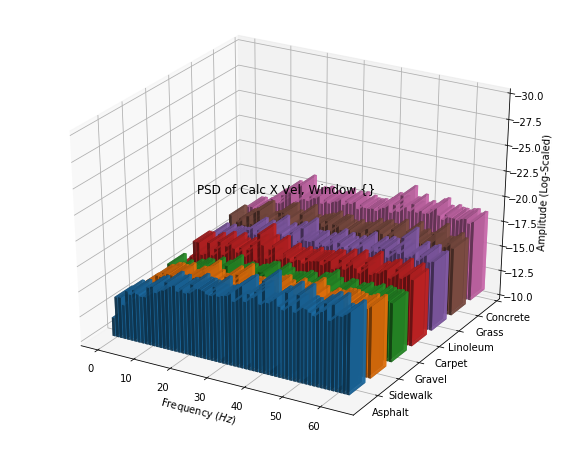

In [51]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [52]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

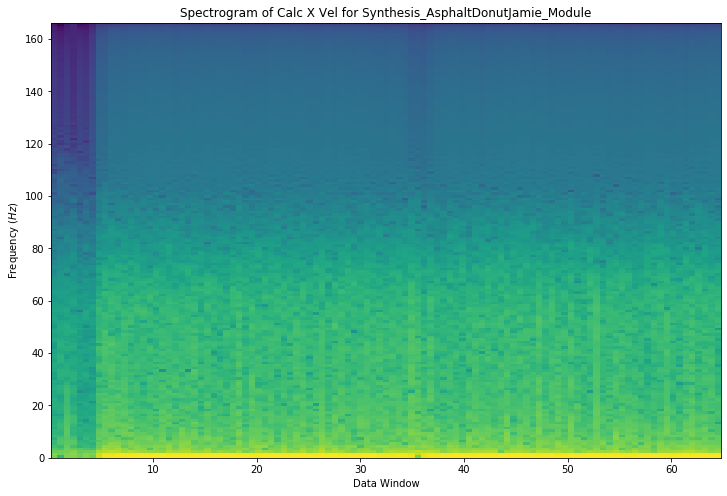

In [53]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [54]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [55]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [56]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [57]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [58]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['Calc X Accel'].shape))

Num datasets: 80
Num directions: 17
Shape of first dataset first direction: (65, 10)


<Figure size 432x288 with 0 Axes>

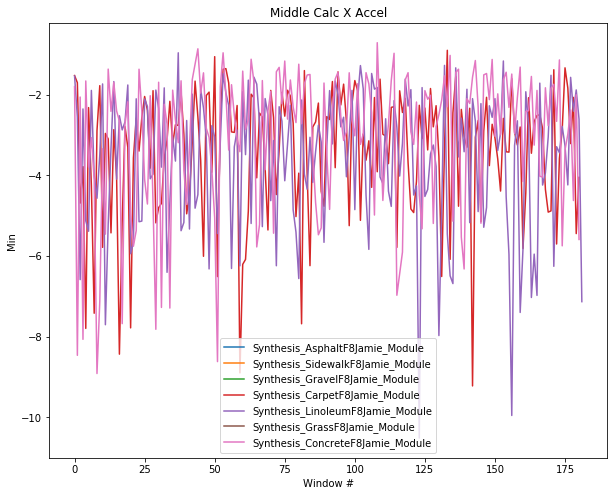

In [59]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Synthesis' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [60]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [61]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['Calc X Vel'].shape))

Num datasets: 80
Num directions: 17
Shape of one direction: (65, 5)


<Figure size 432x288 with 0 Axes>

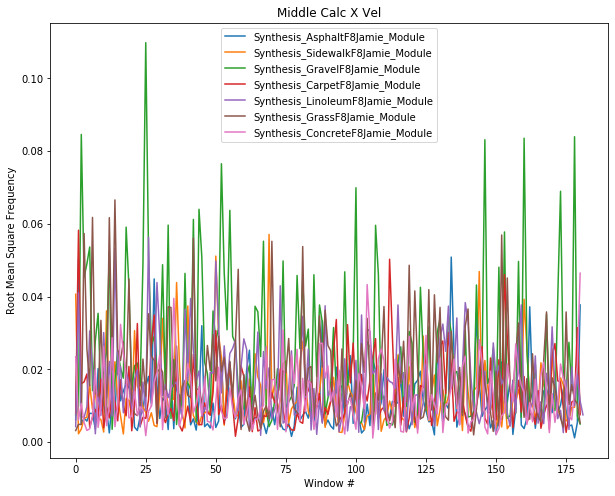

In [62]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [63]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [64]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [65]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [66]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['Calc X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,-0.007493,0.184710,3.373422,11.379976,2.487657,-0.546383,0.184862,0.099099,7.527321,99.178396,0.011649,0.107931,25.906117,-671.115233,0.107931
1,-0.035101,0.293164,5.387956,29.030075,1.660101,-0.697687,0.295258,0.090090,2.549512,11.176626,0.037241,0.192980,15.194111,-230.823779,0.192980
2,0.022194,0.155540,2.867089,8.220199,0.694861,-0.364343,0.157116,0.090090,1.061655,1.745465,0.006587,0.081161,12.160665,-147.875183,0.081161
3,0.001312,0.099546,1.816694,3.300376,0.300109,-0.254485,0.099554,0.120120,0.387124,-0.229155,0.002011,0.044848,12.969883,-168.215857,0.044848
4,0.377406,0.541345,12.042342,145.018004,3.243542,-0.390159,0.659916,0.087087,1.963117,4.842136,0.030264,0.173964,9.899288,-97.965643,0.173964


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [67]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [68]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [69]:
datasets_feat_norm[dataset_labels[0]]['Calc X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,-0.195716,-2.220518,-2.232906,-1.350816,-0.785624,1.665308,-2.232906,-1.076189,5.205256,7.394858,-1.394178,-2.230452,1.710872,-1.719872,-2.230452
1,-0.380157,-1.934760,-1.943854,-1.290571,-1.112046,1.586506,-1.943854,-1.314392,1.519829,0.416824,-1.306441,-1.850243,-0.559591,0.566401,-1.850243
2,0.002616,-2.297377,-2.305556,-1.361601,-1.492775,1.760117,-2.305556,-1.314392,0.418262,-0.331012,-1.411533,-2.350127,-1.202545,0.997123,-2.350127
3,-0.136893,-2.444913,-2.456271,-1.378394,-1.648481,1.817333,-2.456271,-0.520382,-0.081141,-0.487588,-1.427220,-2.512462,-1.031027,0.891502,-2.512462
4,2.375700,-1.280845,-0.989061,-0.894667,-0.487473,1.746672,-0.989061,-1.393793,1.085679,-0.085464,-1.330362,-1.935251,-1.681855,1.256285,-1.935251


<Figure size 432x288 with 0 Axes>

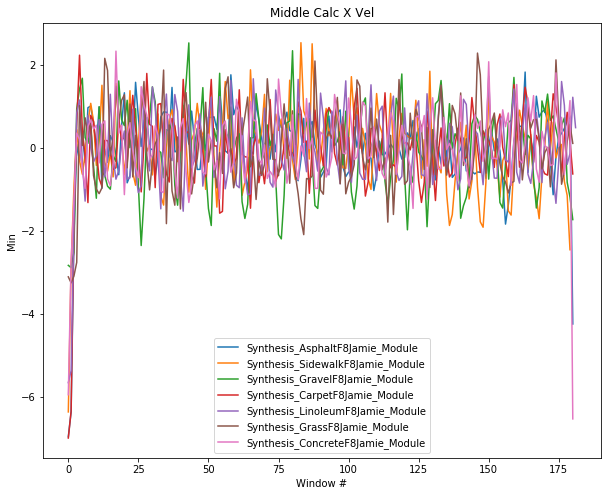

In [70]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Synthesis' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

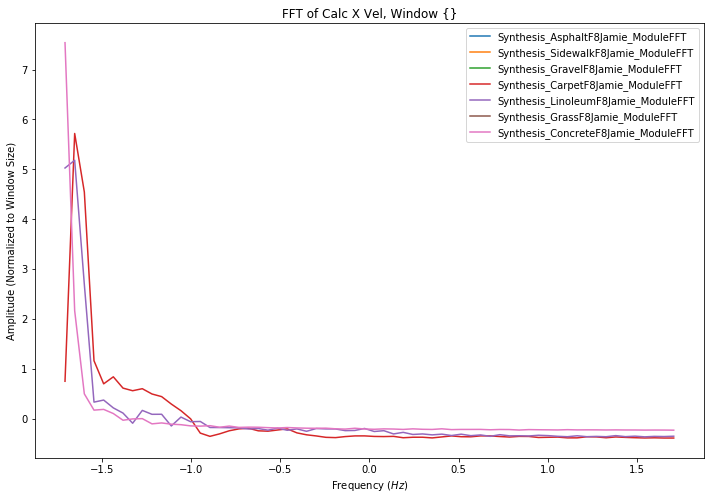

In [71]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [72]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [73]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [74]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,Excess Kurtosis Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,-0.195716,-2.220518,-2.232906,-1.350816,-0.785624,1.665308,-2.232906,-1.076189,5.205256,7.394858,...,3.192422,-2.888952,3.464102,0.197634,-0.307213,-0.663295,-1.143299,-0.780503,0.585830,-1.143299
1,-0.380157,-1.934760,-1.943854,-1.290571,-1.112046,1.586506,-1.943854,-1.314392,1.519829,0.416824,...,3.197748,-2.932043,5.340490,-1.228032,-0.021475,-0.666505,-1.197924,1.392228,-1.110385,-1.197924
2,0.002616,-2.297377,-2.305556,-1.361601,-1.492775,1.760117,-2.305556,-1.314392,0.418262,-0.331012,...,3.187486,-2.916987,3.464102,-0.745262,-1.329734,-0.668313,-1.258645,-1.053636,0.642536,-1.258645
3,-0.136893,-2.444913,-2.456271,-1.378394,-1.648481,1.817333,-2.456271,-0.520382,-0.081141,-0.487588,...,0.398851,-1.367880,-0.288675,-1.003062,-0.960170,2.380361,2.193926,0.060045,0.206609,2.193926
4,2.375700,-1.280845,-0.989061,-0.894667,-0.487473,1.746672,-0.989061,-1.393793,1.085679,-0.085464,...,-0.329856,-0.128444,-0.288675,-0.544613,-0.365480,-0.233957,0.026894,-0.762678,0.582980,0.026894


#### Part (ii) - Transformed Data

In [75]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [76]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [77]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [78]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,FFT 63.0 Hz Left X Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,0.000119,0.000057,0.000272,0.000218,0.008204,0.006165,0.002893,0.000120,0.000050,0.000052,...,0.011726,0.003487,0.007070,9.499429,0.607022,7.826430,5.381485,0.000083,0.003437,0.007493
1,0.000258,0.000059,0.000163,0.002006,0.002119,0.001940,0.001392,0.000331,0.000039,0.000160,...,0.036686,0.014443,0.015163,9.522710,0.604425,7.881343,5.304841,0.015945,0.006677,0.035101
2,0.000140,0.000029,0.000077,0.003293,0.001360,0.001249,0.000841,0.000164,0.000071,0.000178,...,0.029733,0.005252,0.001267,9.523742,0.610916,8.209114,4.823739,0.007734,0.010782,0.022194
3,0.010535,0.000700,0.003020,0.002056,0.018011,0.029691,0.055117,0.000028,0.000007,0.000040,...,0.031650,0.001404,0.003845,9.524051,0.611877,8.170064,4.887618,0.007494,0.007388,0.001312
4,0.002617,0.002030,0.001086,0.008322,0.085000,0.077945,0.066095,0.001924,0.001600,0.001181,...,0.123225,0.097598,0.077095,9.511473,0.596868,8.105542,4.972867,0.108132,0.064466,0.377406
5,0.001207,0.003561,0.004810,0.120011,0.130790,0.142123,0.036698,0.003997,0.003644,0.001934,...,2.055595,0.058838,0.638116,9.524290,0.016257,0.512425,7.035934,0.671528,0.780998,0.404331
6,0.000154,0.004457,0.004572,0.023346,0.230288,0.048447,0.187876,0.000869,0.003115,0.001580,...,3.254963,0.043893,0.331527,10.264708,0.269779,1.875397,4.937676,0.653302,1.130073,0.249471
7,0.000971,0.002539,0.007483,0.040654,0.250775,0.135739,0.046038,0.002151,0.004442,0.001812,...,3.039567,0.455132,0.618149,9.550475,0.334430,2.050454,5.098967,1.024575,1.163062,0.134743
8,0.000621,0.002385,0.005759,0.038199,0.027782,0.092751,0.094509,0.001173,0.004361,0.003019,...,3.527772,0.055974,0.534505,10.315917,0.482712,1.652308,5.911398,0.973139,1.293709,0.138843
9,0.000567,0.000776,0.001737,0.155726,0.037378,0.004290,0.040907,0.001298,0.005914,0.001739,...,3.652379,0.098641,0.661694,9.659507,0.676948,1.219170,4.709709,1.120265,1.368721,0.085347


In [79]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,PSD 63.0 Hz Left X Gyro Synthesis,...,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis,PSD 0.0 Hz Calc X Accel Synthesis
0,-7.781528,-7.695504,-6.725101,-5.817000,-3.999862,-4.422017,-5.726306,-7.933129,-8.391360,-7.931689,...,-2.952449,-4.543252,-5.111531,-5.277048,-3.762166,-2.173397,-1.870088,-4.526701,-3.903038,-2.328324
1,-6.861473,-8.570136,-7.145687,-5.370132,-4.925608,-5.218298,-5.247452,-6.664060,-8.376888,-7.940950,...,-2.723452,-3.027902,-3.280513,-2.960272,-4.649983,-2.513145,-2.229106,-2.849768,-5.020179,-2.990991
2,-7.499338,-8.223256,-8.444428,-4.923520,-7.153935,-5.627506,-6.525706,-7.110618,-8.350210,-7.479585,...,-2.910591,-3.650336,-4.359756,-4.506477,-3.430915,-3.041612,-2.707835,-3.828622,-3.775853,-2.382601
3,-3.675830,-5.527851,-5.029309,-4.803993,-3.069147,-3.557149,-2.213150,-8.765268,-8.346963,-7.920846,...,-2.738242,-4.773293,-5.070784,-4.204040,-4.531249,-1.830428,-1.447279,-4.176883,-3.872815,-2.279555
4,-4.801799,-6.010834,-4.959675,-3.878967,-2.657347,-2.739861,-2.477641,-5.152231,-5.303206,-5.514384,...,-1.681559,-1.902916,-2.137001,-4.632432,-5.061442,-2.281447,-1.920336,-1.777748,-2.245374,-0.917112
5,-5.306128,-4.663692,-4.734302,-1.633472,-1.344319,-1.635715,-3.038432,-4.535742,-4.964402,-5.408238,...,-0.971422,-0.966045,-1.245998,-2.121221,-1.567640,1.402974,0.466317,-1.614037,-1.727024,-0.066129
6,-6.741169,-4.915079,-5.491423,-3.441424,-1.794073,-2.783662,-1.630321,-6.301752,-4.146350,-5.231154,...,-0.442463,-0.758768,-1.275684,-1.187736,-1.150576,1.651364,1.233977,-2.039742,-1.628435,0.058285
7,-5.822463,-4.310511,-5.128799,-1.931386,-0.741953,-2.517292,-2.409871,-4.833004,-4.575288,-4.711342,...,-1.797087,-0.467167,-0.830376,-1.364202,-1.553622,1.477461,1.155937,-1.447824,-2.199134,-0.367949
8,-5.685568,-4.960268,-4.942709,-1.876704,-1.256683,-2.338198,-1.710466,-5.913242,-4.380307,-5.565886,...,-1.654217,-0.392100,-0.849671,-1.061170,-1.421585,1.557831,1.160622,-2.163015,-2.490859,-0.525172
9,-7.523385,-4.839462,-5.859563,-2.370699,-2.517540,-2.273759,-1.712181,-5.985641,-4.533152,-4.545847,...,-2.452130,-0.325291,-0.571589,-0.981623,-2.007985,1.576704,1.174638,-1.615609,-3.130869,-1.093908


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [80]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [81]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [82]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,3,-0.195716,-2.220518,-2.232906,-1.350816,-0.785624,1.665308,-2.232906,-1.076189,5.205256,...,3.192422,-2.888952,3.464102,0.197634,-0.307213,-0.663295,-1.143299,-0.780503,0.585830,-1.143299
1,3,-0.380157,-1.934760,-1.943854,-1.290571,-1.112046,1.586506,-1.943854,-1.314392,1.519829,...,3.197748,-2.932043,5.340490,-1.228032,-0.021475,-0.666505,-1.197924,1.392228,-1.110385,-1.197924
2,3,0.002616,-2.297377,-2.305556,-1.361601,-1.492775,1.760117,-2.305556,-1.314392,0.418262,...,3.187486,-2.916987,3.464102,-0.745262,-1.329734,-0.668313,-1.258645,-1.053636,0.642536,-1.258645
3,3,-0.136893,-2.444913,-2.456271,-1.378394,-1.648481,1.817333,-2.456271,-0.520382,-0.081141,...,0.398851,-1.367880,-0.288675,-1.003062,-0.960170,2.380361,2.193926,0.060045,0.206609,2.193926
4,3,2.375700,-1.280845,-0.989061,-0.894667,-0.487473,1.746672,-0.989061,-1.393793,1.085679,...,-0.329856,-0.128444,-0.288675,-0.544613,-0.365480,-0.233957,0.026894,-0.762678,0.582980,0.026894


In [83]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,3,0.000119,0.000057,0.000272,0.000218,0.008204,0.006165,0.002893,0.000120,0.000050,...,0.011726,0.003487,0.007070,9.499429,0.607022,7.826430,5.381485,0.000083,0.003437,0.007493
1,3,0.000258,0.000059,0.000163,0.002006,0.002119,0.001940,0.001392,0.000331,0.000039,...,0.036686,0.014443,0.015163,9.522710,0.604425,7.881343,5.304841,0.015945,0.006677,0.035101
2,3,0.000140,0.000029,0.000077,0.003293,0.001360,0.001249,0.000841,0.000164,0.000071,...,0.029733,0.005252,0.001267,9.523742,0.610916,8.209114,4.823739,0.007734,0.010782,0.022194
3,3,0.010535,0.000700,0.003020,0.002056,0.018011,0.029691,0.055117,0.000028,0.000007,...,0.031650,0.001404,0.003845,9.524051,0.611877,8.170064,4.887618,0.007494,0.007388,0.001312
4,3,0.002617,0.002030,0.001086,0.008322,0.085000,0.077945,0.066095,0.001924,0.001600,...,0.123225,0.097598,0.077095,9.511473,0.596868,8.105542,4.972867,0.108132,0.064466,0.377406


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [84]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [85]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [86]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Jamie')

feat_combined['Synthesis'].tail()

,Label,Mean Calc X Vel Synthesis,Std Dev Calc X Vel Synthesis,L2 Norm Calc X Vel Synthesis,Autocorrelation Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,Root Mean Squared Calc X Vel Synthesis,Zero Crossing Rate Calc X Vel Synthesis,Skew Calc X Vel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
2108,0,0.294702,-1.019252,0.269739,0.207394,-0.255124,0.739868,0.269739,0.0,-0.911068,...,-0.950835,0.979119,0.0,0.413206,0.003165,-0.600465,-0.632089,-0.623151,0.452935,-0.632089
2109,0,-0.524888,0.526325,-0.521474,-0.560279,-0.191722,-0.638777,-0.521474,0.0,0.692843,...,-0.998931,0.837162,0.0,-0.450933,-0.462773,0.151399,0.459151,-0.812207,0.497358,0.459151
2110,0,0.334226,0.977785,0.360175,0.300180,0.913627,0.378303,0.360175,0.0,1.015138,...,-0.878321,0.959502,0.0,0.298512,-0.603394,-0.778970,-1.238132,-0.954781,0.517516,-1.238132
2111,0,1.231850,-0.635312,1.223458,1.237935,0.877355,1.143715,1.223458,0.0,-0.797968,...,-0.855785,0.619438,0.0,-0.498190,0.841851,1.417715,1.523341,2.644546,-2.632500,1.523341
2112,0,-3.147269,6.420066,-2.455205,-2.103402,-0.815366,-6.536407,-2.455205,0.0,-0.577581,...,0.719941,-1.349885,0.0,0.057207,-1.086845,2.382990,2.134543,0.425473,-0.047083,2.134543


In [87]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Jamie')

fft_combined['Synthesis'].tail()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Right X Accel Synthesis,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis
2108,0,0.000927,0.005524,0.003476,0.019255,0.006509,0.038846,0.018313,0.000236,0.002486,...,3.797643,2.401530,0.835125,0.226101,9.776666,0.287723,6.732942,2.817612,1.035198,0.977603
2109,0,0.001034,0.006081,0.004076,0.019679,0.039673,0.046978,0.007911,0.001297,0.006807,...,3.981413,1.850561,0.360000,1.068371,9.495360,0.040907,2.899338,7.610591,1.273284,0.876969
2110,0,0.000652,0.000485,0.005429,0.006992,0.008150,0.011737,0.036363,0.004509,0.004595,...,0.137669,2.418177,0.766909,0.247084,10.137719,0.183552,7.242783,3.933860,1.034975,0.982456
2111,0,0.004399,0.001009,0.001776,0.003326,0.012528,0.043526,0.017843,0.000235,0.000248,...,4.630946,3.565737,0.274071,0.041127,9.486096,0.594181,4.059732,2.075934,0.156838,1.092670
2112,0,0.007908,0.001179,0.000468,0.007254,0.016359,0.024495,0.021119,0.009170,0.000283,...,7.312824,2.153618,0.353531,0.134741,10.355205,0.596838,5.259138,5.646658,0.308988,0.554980


In [88]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Jamie')

psd_log_combined['Synthesis'].tail()

,Label,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,...,PSD 0.0 Hz Right X Accel Synthesis,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis
2108,0,-5.822260,-4.253913,-4.690515,-4.625774,-4.088338,-2.339200,-2.979242,-7.351570,-4.997239,...,1.416030,-1.917325,-1.381889,-0.560536,-1.086105,-1.562945,0.794368,1.378348,-1.366440,-3.086925
2109,0,-5.656547,-4.221222,-4.350837,-3.351848,-2.496307,-2.793191,-3.234539,-5.480101,-4.024884,...,1.453535,-0.912479,-0.487731,-3.197142,-1.824197,-1.657116,1.121681,0.136407,-1.386590,-2.070756
2110,0,-6.184848,-6.264024,-4.316392,-4.339622,-3.113413,-3.979986,-2.920950,-4.407339,-4.342331,...,1.633253,-0.583650,-0.701078,-0.872267,-1.196113,-2.360308,0.872537,1.207225,-1.217250,-1.991058
2111,0,-4.411426,-5.748570,-5.282700,-4.041851,-3.171741,-2.450895,-3.263650,-6.925012,-6.917062,...,1.288304,-2.589110,-2.092484,-1.521943,-1.092674,-0.895545,1.317973,1.542306,-1.927711,-3.205089
2112,0,-3.910445,-5.544640,-7.239312,-3.656699,-3.335432,-3.109462,-2.751145,-3.780041,-5.846865,...,0.721282,0.163506,-1.075682,-1.474250,-1.124990,-1.421552,1.092448,1.362856,-1.159757,-1.080862


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right